## Модели прогнозирования количества яиц по Акмолинской области

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from IPython.display import display
import math
from prophet import Prophet
pd.set_option('display.max_columns', 130)


import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Подготовка данных и EDA

In [25]:
df = pd.read_excel("Датасет по яйцам.xlsx")
df = df[['Регион', 'Период', 'Яйца', 'Осадки', 'Поголовье: птица домашняя', 'Температура']]
df.sample(10)

,Регион,Период,Яйца,Осадки,Поголовье: птица домашняя,Температура
1447,КЫЗЫЛОРДИНСКАЯ ОБЛАСТЬ,2019-01,581.3,19.4,126431.0,-3.361290
180,АКТЮБИНСКАЯ ОБЛАСТЬ,2020-01,19740.8,30.1,1310547.0,-5.767742
1774,ПАВЛОДАРСКАЯ ОБЛАСТЬ,2018-07,19774.8,60.4,1672081.0,20.525806
807,ГАСТАНА,2022-04,0.3,7.1,3068.0,9.770000
141,АКТЮБИНСКАЯ ОБЛАСТЬ,2016-10,16154.6,31.6,1336216.0,3.980645
303,АЛМАТИНСКАЯ ОБЛАСТЬ,2020-04,91300.4,99.7,11241426.0,12.516667
336,АЛМАТИНСКАЯ ОБЛАСТЬ,2023-01,40590.3,20.8,9073713.0,-10.532258
739,ГАСТАНА,2016-08,14.9,3.9,991.0,20.119355
1512,КЫЗЫЛОРДИНСКАЯ ОБЛАСТЬ,2024-06,861.5,2.4,127612.0,29.303333
2167,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-09,22847.1,0.5,2092996.0,20.766667


In [26]:
df_akmola = df[df['Регион'] == 'АКМОЛИНСКАЯ ОБЛАСТЬ']
df_akmola = df_akmola.drop('Регион', axis = 'columns')
df_akmola.head()

,Период,Яйца,Осадки,Поголовье: птица домашняя,Температура
0,2015-01,51667.7,9.8,4436655.0,-12.490323
1,2015-02,49357.2,9.8,4446764.0,-10.192857
2,2015-03,59105.8,8.3,4461524.0,-5.870968
3,2015-04,61953.7,8.8,4575245.0,4.490000
4,2015-05,72700.2,42.8,4778690.0,14.574194


In [27]:
df_akmola = df_akmola.rename(columns={'Яйца': 'Кол-во яиц'})
df_akmola.head()

,Период,Кол-во яиц,Осадки,Поголовье: птица домашняя,Температура
0,2015-01,51667.7,9.8,4436655.0,-12.490323
1,2015-02,49357.2,9.8,4446764.0,-10.192857
2,2015-03,59105.8,8.3,4461524.0,-5.870968
3,2015-04,61953.7,8.8,4575245.0,4.490000
4,2015-05,72700.2,42.8,4778690.0,14.574194


In [28]:
df_akmola['Период'] = pd.to_datetime(df_akmola['Период'], format='%Y-%m')
df_akmola.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Период                     120 non-null    datetime64[ns]
 1   Кол-во яиц                 120 non-null    float64       
 2   Осадки                     120 non-null    float64       
 3   Поголовье: птица домашняя  120 non-null    float64       
 4   Температура                120 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 5.6 KB


In [29]:
df_akmola.isna().sum()

Период                       0
Кол-во яиц                   0
Осадки                       0
Поголовье: птица домашняя    0
Температура                  0
dtype: int64

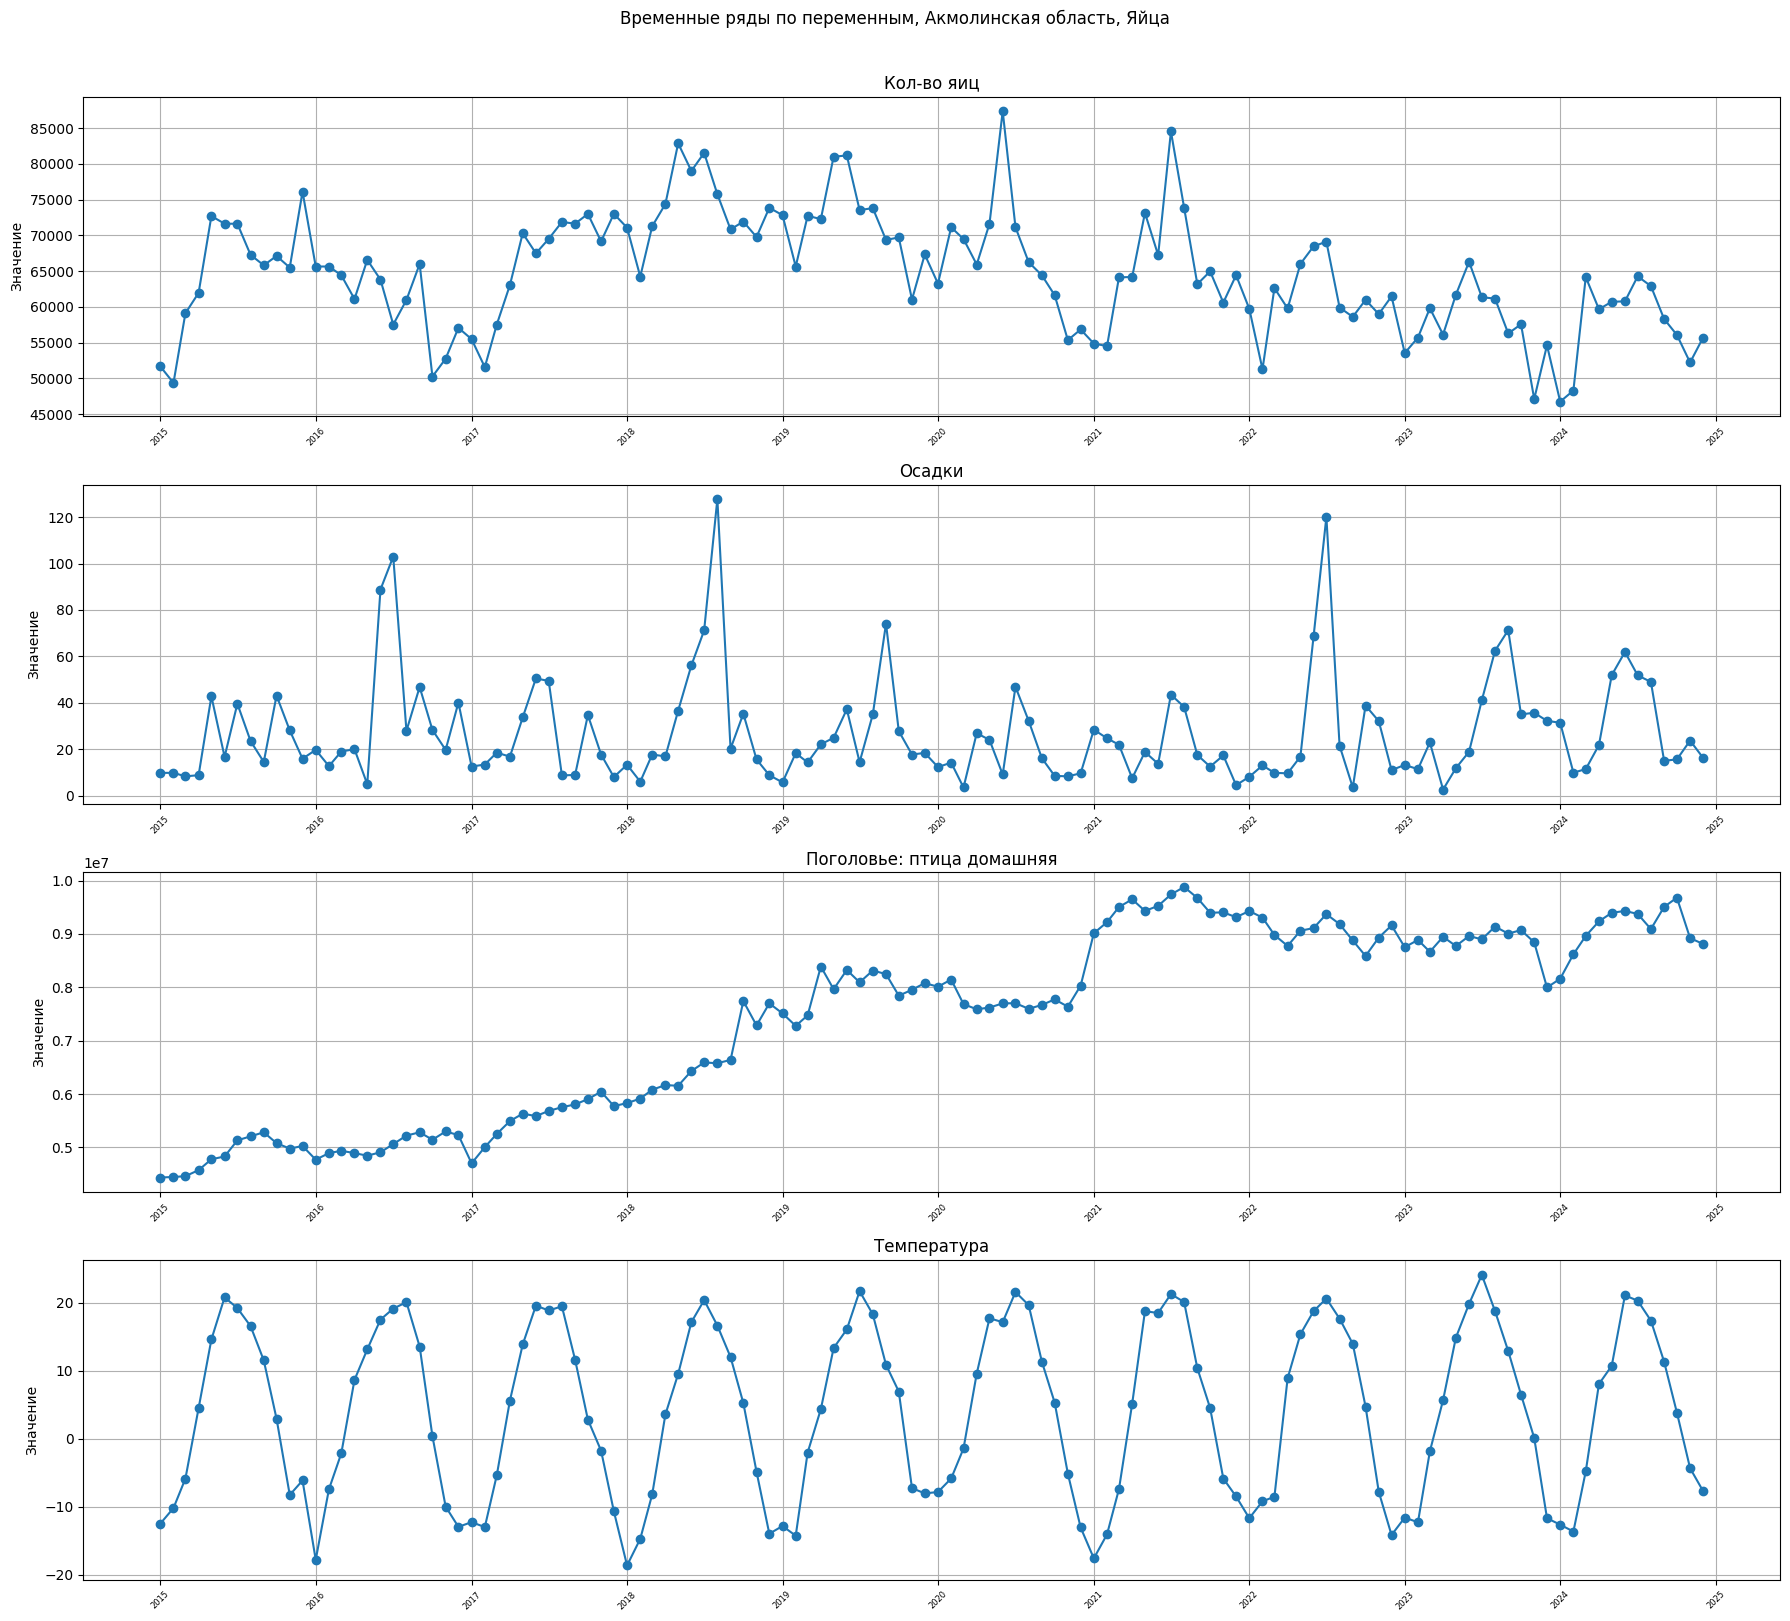

In [30]:
# Plot each variable in its own subplot
value_cols = [col for col in df_akmola.columns if col not in ["Период"]]

n = len(value_cols)
plt.figure(figsize=(18, 4 * n))

for i, col in enumerate(value_cols, 1):
    plt.subplot(n, 1, i)
    plt.plot(df_akmola["Период"], df_akmola[col], marker="o")
    plt.title(f"{col}")
    plt.grid(True)
    plt.ylabel("Значение")
    plt.xticks(rotation=45, fontsize = 6)

plt.suptitle("Временные ряды по переменным, Акмолинская область, Яйца", y=1.01)
plt.tight_layout()
plt.show()

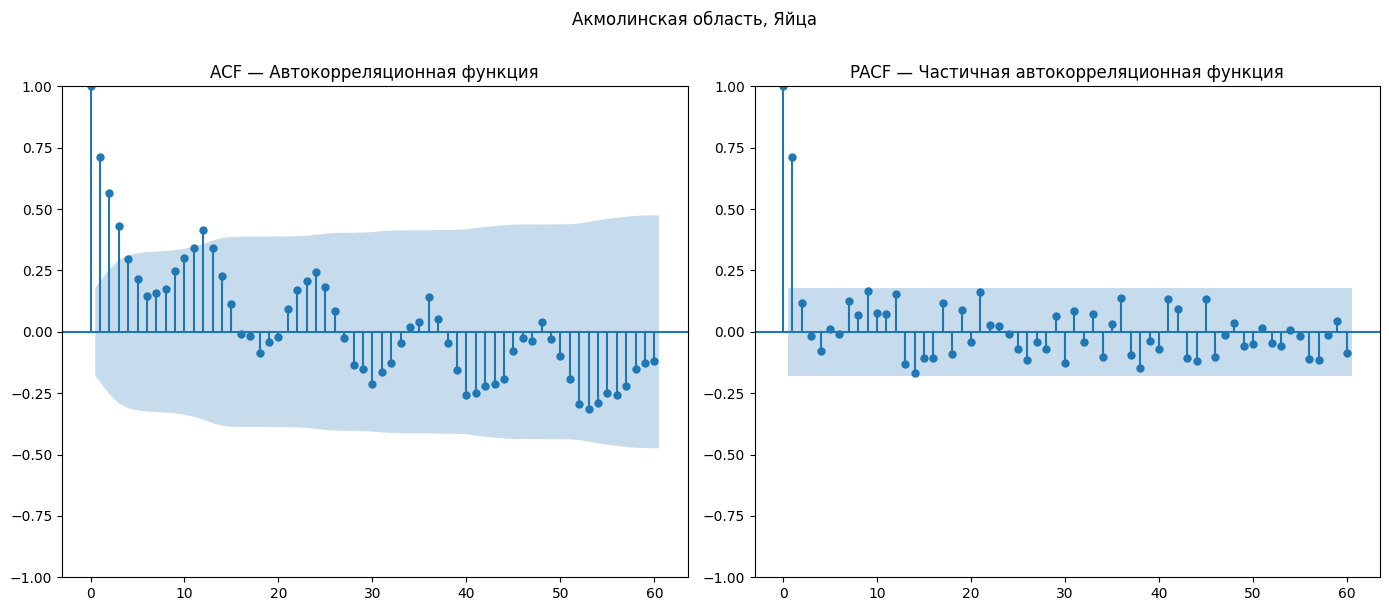

In [31]:
y = df_akmola["Кол-во яиц"].sort_index()

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(y, lags=60, ax=plt.gca(), title="ACF — Автокорреляционная функция")

plt.subplot(1, 2, 2)
plot_pacf(y, lags=60, ax=plt.gca(), title="PACF — Частичная автокорреляционная функция", method="ywm")
plt.suptitle("Акмолинская область, Яйца", y=1.01)

plt.tight_layout()
plt.show()

Графики автокорреляционной и частичной автокорреляционной функций указывают на **сильную взаимосвязь показателей текущего месяца со значениями следующих 3 месяцев** и на возможную **годовую сезонность** (пик на +12 месяцев). 

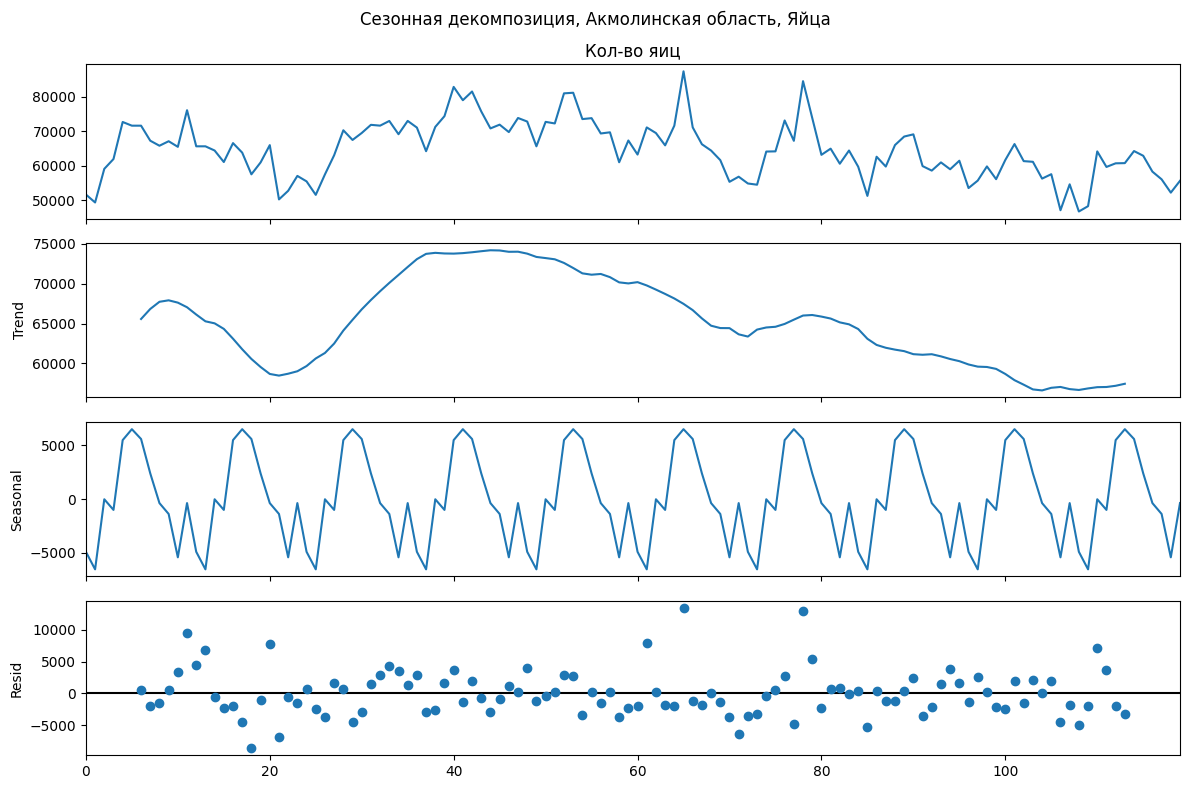

In [32]:
# Perform decomposition (period=12 for monthly data)
decomposition = seasonal_decompose(df_akmola["Кол-во яиц"], model="additive", period=12)

# Plot with larger figure size
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Сезонная декомпозиция, Акмолинская область, Яйца", fontsize=12)
plt.tight_layout()
plt.show()


In [33]:
# Run ADF test
result = adfuller(df_akmola["Кол-во яиц"])

# Display results
print("📊 Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

# Interpretation
if result[1] < 0.05:
    print("✅ The series is likely **stationary** (reject H₀).")
else:
    print("❌ The series is likely **non-stationary** (fail to reject H₀).")


📊 Augmented Dickey-Fuller Test Results:
ADF Statistic: -3.6259
p-value: 0.0053
Critical Value (1%): -3.4870
Critical Value (5%): -2.8864
Critical Value (10%): -2.5800
✅ The series is likely **stationary** (reject H₀).


Результаты теста ADF указывают на **нестационарность** временного ряда.

In [34]:
df_akmola

,Период,Кол-во яиц,Осадки,Поголовье: птица домашняя,Температура
0,2015-01-01,51667.7,9.8,4436655.0,-12.490323
1,2015-02-01,49357.2,9.8,4446764.0,-10.192857
2,2015-03-01,59105.8,8.3,4461524.0,-5.870968
3,2015-04-01,61953.7,8.8,4575245.0,4.490000
4,2015-05-01,72700.2,42.8,4778690.0,14.574194
...,...,...,...,...,...
115,2024-08-01,62899.9,49.0,9092081.0,17.338710
116,2024-09-01,58300.1,15.0,9507343.0,11.300000
117,2024-10-01,56071.5,15.6,9680147.0,3.832258
118,2024-11-01,52213.7,23.7,8922229.0,-4.343333


In [35]:
# Создание лагов t-1 до t-6 для переменных
for lag in range(1, 7):
    df_akmola[f"Яйца_t-{lag}"] = df_akmola["Кол-во яиц"].shift(lag)
    df_akmola[f"Температура_t-{lag}"] = df_akmola["Температура"].shift(lag)
    df_akmola[f"Осадки_t-{lag}"] = df_akmola["Осадки"].shift(lag)
    df_akmola[f"Поголовье: птица домашняя_t-{lag}"] = df_akmola["Поголовье: птица домашняя"].shift(lag)

df_akmola_full = df_akmola[["Период", "Кол-во яиц", 
                            "Яйца_t-1", "Яйца_t-2", "Яйца_t-3", "Яйца_t-4", "Яйца_t-5", "Яйца_t-6",
                            "Температура", "Температура_t-1", "Температура_t-2", "Температура_t-3", "Температура_t-4", "Температура_t-5", "Температура_t-6",
                            "Осадки", "Осадки_t-1", "Осадки_t-2", "Осадки_t-3", "Осадки_t-4", "Осадки_t-5", "Осадки_t-6",
                            "Поголовье: птица домашняя", "Поголовье: птица домашняя_t-1", "Поголовье: птица домашняя_t-2", "Поголовье: птица домашняя_t-3", "Поголовье: птица домашняя_t-4", "Поголовье: птица домашняя_t-5", "Поголовье: птица домашняя_t-6"]]
df_akmola_full

,Период,Кол-во яиц,Яйца_t-1,Яйца_t-2,Яйца_t-3,Яйца_t-4,Яйца_t-5,Яйца_t-6,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Температура_t-5,Температура_t-6,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Осадки_t-5,Осадки_t-6,Поголовье: птица домашняя,Поголовье: птица домашняя_t-1,Поголовье: птица домашняя_t-2,Поголовье: птица домашняя_t-3,Поголовье: птица домашняя_t-4,Поголовье: птица домашняя_t-5,Поголовье: птица домашняя_t-6
0,2015-01-01,51667.7,NaN,NaN,NaN,NaN,NaN,NaN,-12.490323,NaN,NaN,NaN,NaN,NaN,NaN,9.8,NaN,NaN,NaN,NaN,NaN,NaN,4436655.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-01,49357.2,51667.7,NaN,NaN,NaN,NaN,NaN,-10.192857,-12.490323,NaN,NaN,NaN,NaN,NaN,9.8,9.8,NaN,NaN,NaN,NaN,NaN,4446764.0,4436655.0,NaN,NaN,NaN,NaN,NaN
2,2015-03-01,59105.8,49357.2,51667.7,NaN,NaN,NaN,NaN,-5.870968,-10.192857,-12.490323,NaN,NaN,NaN,NaN,8.3,9.8,9.8,NaN,NaN,NaN,NaN,4461524.0,4446764.0,4436655.0,NaN,NaN,NaN,NaN
3,2015-04-01,61953.7,59105.8,49357.2,51667.7,NaN,NaN,NaN,4.490000,-5.870968,-10.192857,-12.490323,NaN,NaN,NaN,8.8,8.3,9.8,9.8,NaN,NaN,NaN,4575245.0,4461524.0,4446764.0,4436655.0,NaN,NaN,NaN
4,2015-05-01,72700.2,61953.7,59105.8,49357.2,51667.7,NaN,NaN,14.574194,4.490000,-5.870968,-10.192857,-12.490323,NaN,NaN,42.8,8.8,8.3,9.8,9.8,NaN,NaN,4778690.0,4575245.0,4461524.0,4446764.0,4436655.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-08-01,62899.9,64270.3,60767.6,60711.6,59663.6,64167.2,48287.8,17.338710,20.270968,21.043333,10.696774,8.026667,-4.809677,-13.644828,49.0,51.8,61.9,51.9,21.8,11.4,9.9,9092081.0,9375655.0,9431792.0,9396776.0,9236538.0,8963506.0,8620009.0
116,2024-09-01,58300.1,62899.9,64270.3,60767.6,60711.6,59663.6,64167.2,11.300000,17.338710,20.270968,21.043333,10.696774,8.026667,-4.809677,15.0,49.0,51.8,61.9,51.9,21.8,11.4,9507343.0,9092081.0,9375655.0,9431792.0,9396776.0,9236538.0,8963506.0
117,2024-10-01,56071.5,58300.1,62899.9,64270.3,60767.6,60711.6,59663.6,3.832258,11.300000,17.338710,20.270968,21.043333,10.696774,8.026667,15.6,15.0,49.0,51.8,61.9,51.9,21.8,9680147.0,9507343.0,9092081.0,9375655.0,9431792.0,9396776.0,9236538.0
118,2024-11-01,52213.7,56071.5,58300.1,62899.9,64270.3,60767.6,60711.6,-4.343333,3.832258,11.300000,17.338710,20.270968,21.043333,10.696774,23.7,15.6,15.0,49.0,51.8,61.9,51.9,8922229.0,9680147.0,9507343.0,9092081.0,9375655.0,9431792.0,9396776.0


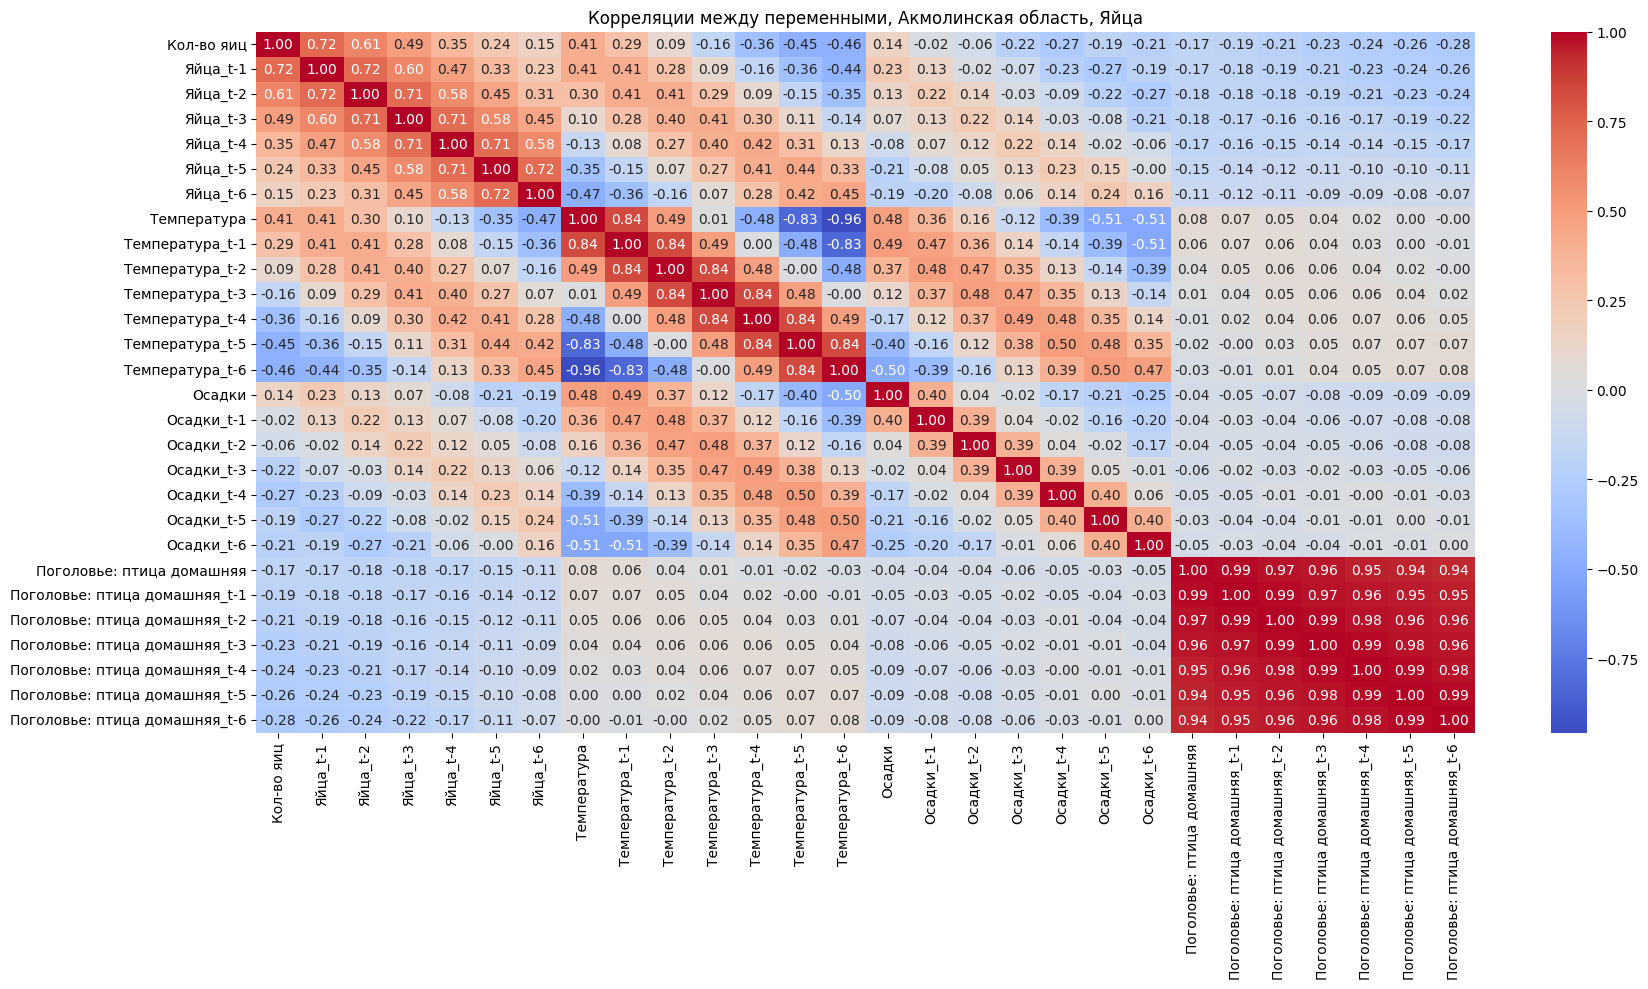

In [36]:
df_corr = df_akmola_full[[col for col in df_akmola_full.columns if col not in ["Период"]]].dropna().copy()

# 1. Correlation matrix
corr_matrix = df_corr.corr()

# 2. Plot heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции между переменными, Акмолинская область, Яйца")
plt.tight_layout()
plt.show()

*ВЫВОДЫ ПО КОРРЕЛЯЦИИ*

In [37]:
# Set your target variable
target_var = "Кол-во яиц"

# Get correlations with the target variable
target_corr = corr_matrix[target_var].drop(target_var)  # exclude self-correlation

# Keep only features with |correlation| >= 0.5
selected_vars = target_corr[abs(target_corr) >= 0.45].index.tolist()

print("✅ Отобранные переменные с корреляцией >= 0.5:")
print(selected_vars)

# Optionally: create new dataframe with selected variables + target
df_selected = df_akmola_full[['Период'] + selected_vars + [target_var]]
df_selected

✅ Отобранные переменные с корреляцией >= 0.5:
['Яйца_t-1', 'Яйца_t-2', 'Яйца_t-3', 'Температура_t-6']


,Период,Яйца_t-1,Яйца_t-2,Яйца_t-3,Температура_t-6,Кол-во яиц
0,2015-01-01,NaN,NaN,NaN,NaN,51667.7
1,2015-02-01,51667.7,NaN,NaN,NaN,49357.2
2,2015-03-01,49357.2,51667.7,NaN,NaN,59105.8
3,2015-04-01,59105.8,49357.2,51667.7,NaN,61953.7
4,2015-05-01,61953.7,59105.8,49357.2,NaN,72700.2
...,...,...,...,...,...,...
115,2024-08-01,64270.3,60767.6,60711.6,-13.644828,62899.9
116,2024-09-01,62899.9,64270.3,60767.6,-4.809677,58300.1
117,2024-10-01,58300.1,62899.9,64270.3,8.026667,56071.5
118,2024-11-01,56071.5,58300.1,62899.9,10.696774,52213.7


In [38]:
df_vif = df_selected[[col for col in df_selected.columns if col not in ["Период"]]].dropna().copy()

X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Кол-во яиц"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data.sort_values('VIF')

,Variable,VIF
4,Температура_t-6,1.324814
3,Яйца_t-3,2.204717
1,Яйца_t-1,2.409284
2,Яйца_t-2,2.869595
0,const,101.403204


Step-by-Step Strategy to Handle High VIFs:

Sort VIFs in descending order
Drop variables one at a time, starting with the one that has the highest VIF.

Check domain relevance
Keep variables that are theoretically important or core to your hypothesis, even if VIF is high.

Evaluate correlation matrix
If two variables have high correlation with each other, and both have high VIFs, drop the one less correlated with the target.

Recalculate VIF after each drop
After dropping one variable, recalculate all VIFs. Sometimes removing just one variable significantly reduces others.

Use stepwise selection (optional)
Automated methods like backward elimination can help drop redundant predictors based on model fit and VIF thresholds.

In [39]:
df_selected = df_selected.drop(columns = ['Яйца_t-3', 'Яйца_t-2'])
df_selected

,Период,Яйца_t-1,Температура_t-6,Кол-во яиц
0,2015-01-01,NaN,NaN,51667.7
1,2015-02-01,51667.7,NaN,49357.2
2,2015-03-01,49357.2,NaN,59105.8
3,2015-04-01,59105.8,NaN,61953.7
4,2015-05-01,61953.7,NaN,72700.2
...,...,...,...,...
115,2024-08-01,64270.3,-13.644828,62899.9
116,2024-09-01,62899.9,-4.809677,58300.1
117,2024-10-01,58300.1,8.026667,56071.5
118,2024-11-01,56071.5,10.696774,52213.7


In [40]:
df_vif = df_selected[[col for col in df_selected.columns if col not in ["Период"]]].dropna().copy()
X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Кол-во яиц"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data.sort_values('VIF')

,Variable,VIF
1,Яйца_t-1,1.245277
2,Температура_t-6,1.245277
0,const,84.797862


In [41]:
df_selected = df_selected.dropna().copy()
df_selected

,Период,Яйца_t-1,Температура_t-6,Кол-во яиц
6,2015-07-01,71629.5,-12.490323,71629.5
7,2015-08-01,71629.5,-10.192857,67269.6
8,2015-09-01,67269.6,-5.870968,65812.8
9,2015-10-01,65812.8,4.490000,67117.6
10,2015-11-01,67117.6,14.574194,65494.2
...,...,...,...,...
115,2024-08-01,64270.3,-13.644828,62899.9
116,2024-09-01,62899.9,-4.809677,58300.1
117,2024-10-01,58300.1,8.026667,56071.5
118,2024-11-01,56071.5,10.696774,52213.7


### Models

#### Многофакторная регрессия

In [42]:
# def forward_selection(data, target, candidate_features, criterion="adj_r2"):
#     remaining = list(candidate_features)
#     selected = []
#     best_score = -float("inf")
#     best_model = None

#     while remaining:
#         scores_with_candidates = []
#         for candidate in remaining:
#             features = selected + [candidate]
#             X = sm.add_constant(data[features])
#             y = data[target]
#             model = sm.OLS(y, X).fit()

#             if criterion == "adj_r2":
#                 score = model.rsquared_adj
#             elif criterion == "aic":
#                 score = -model.aic  # negative for maximizing
#             else:
#                 raise ValueError("criterion must be 'adj_r2' or 'aic'")

#             scores_with_candidates.append((score, candidate, model))

#         scores_with_candidates.sort(reverse=True)
#         best_new_score, best_candidate, model = scores_with_candidates[0]

#         if best_new_score > best_score:
#             remaining.remove(best_candidate)
#             selected.append(best_candidate)
#             best_score = best_new_score
#             best_model = model
#             print(f"✅ Added: {best_candidate}, {criterion.upper()}: {best_score:.4f}")
#         else:
#             print("⛔ No improvement. Stopping.")
#             break

#     return selected, best_model


In [43]:
# Define target and features
y = df_selected["Кол-во яиц"]
X = df_selected.drop(columns=["Период", "Кол-во яиц"])

# Add constant term
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Кол-во яиц   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     66.81
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           8.99e-20
Time:                        20:35:42   Log-Likelihood:                -1142.5
No. Observations:                 114   AIC:                             2291.
Df Residuals:                     111   BIC:                             2299.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.322e+04   4763.587     

In [44]:
df_selected

,Период,Яйца_t-1,Температура_t-6,Кол-во яиц
6,2015-07-01,71629.5,-12.490323,71629.5
7,2015-08-01,71629.5,-10.192857,67269.6
8,2015-09-01,67269.6,-5.870968,65812.8
9,2015-10-01,65812.8,4.490000,67117.6
10,2015-11-01,67117.6,14.574194,65494.2
...,...,...,...,...
115,2024-08-01,64270.3,-13.644828,62899.9
116,2024-09-01,62899.9,-4.809677,58300.1
117,2024-10-01,58300.1,8.026667,56071.5
118,2024-11-01,56071.5,10.696774,52213.7


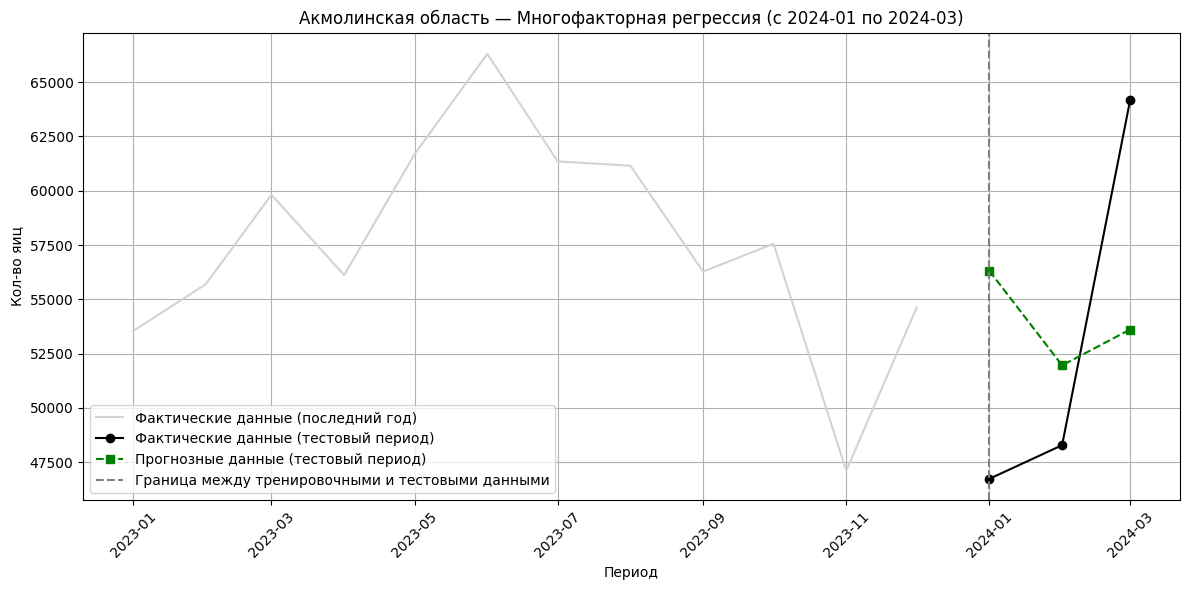

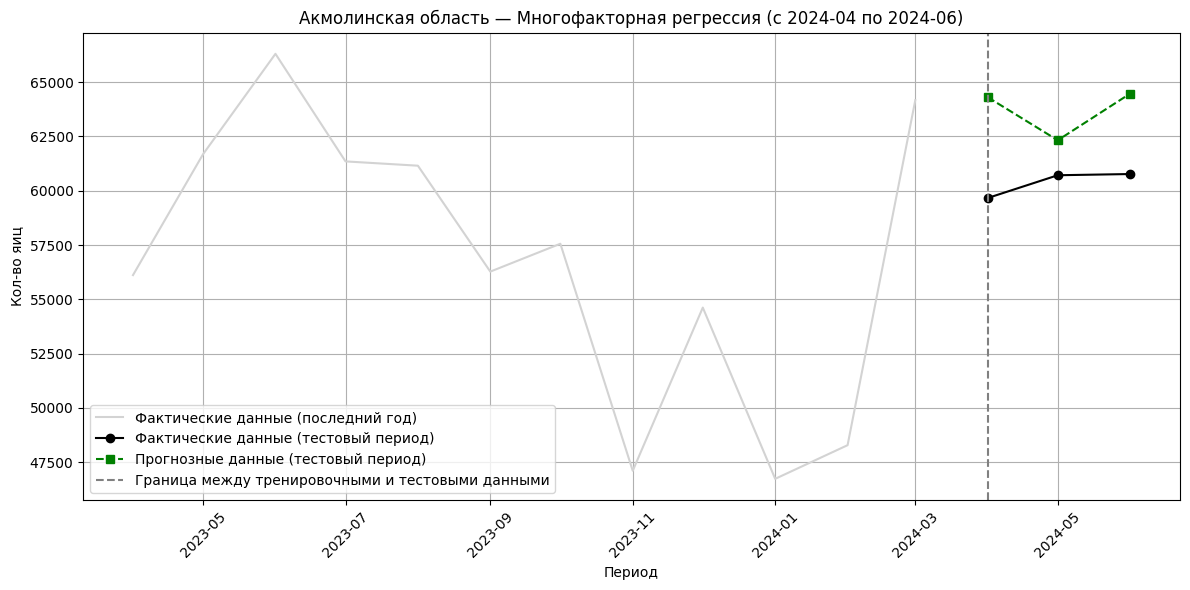

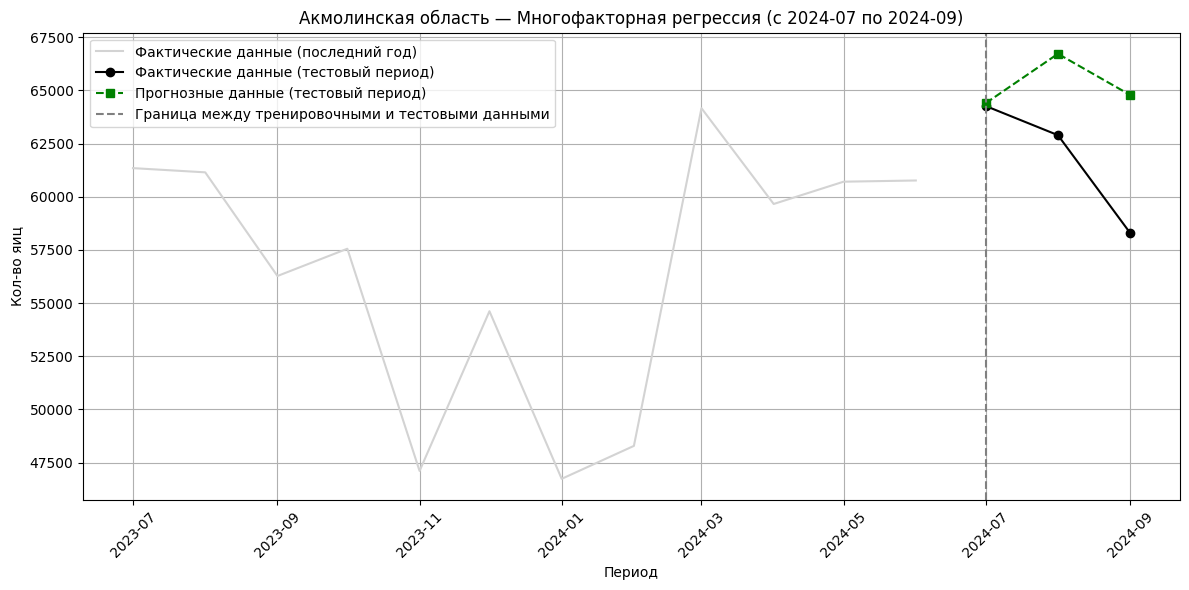

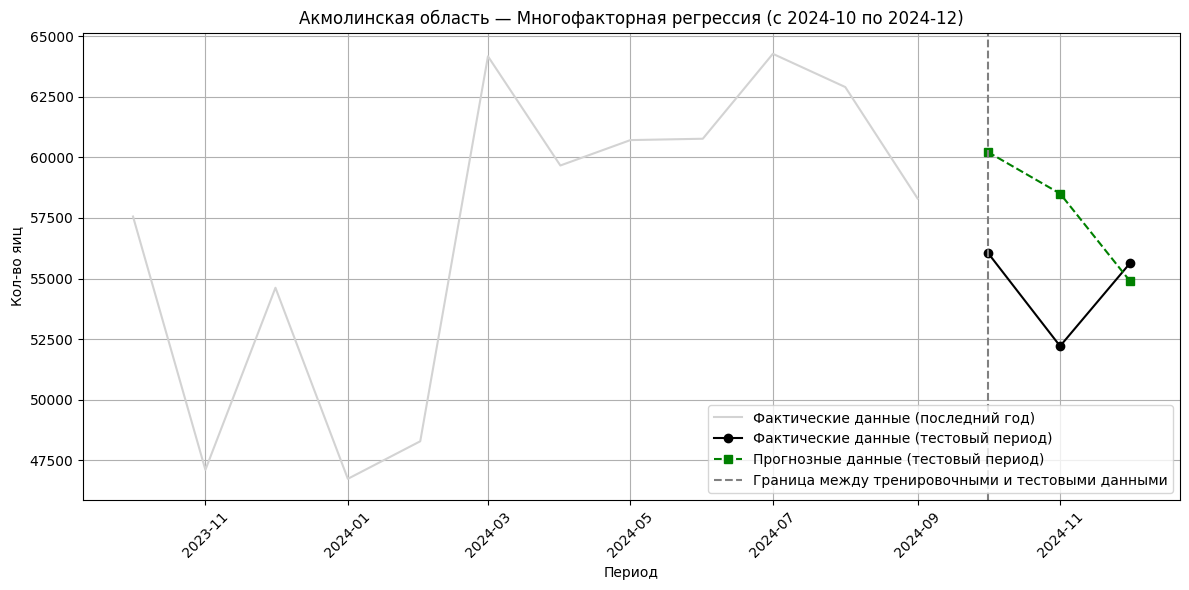

In [45]:
df = df_selected.sort_values("Период").copy()

target = "Кол-во яиц"
features = [col for col in df_selected.columns if col not in ['Период', 'Кол-во яиц']]

results = []

# Define 4 rolling test sets for 2024
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    X_train = sm.add_constant(train_df[features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        # "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Многофакторная регрессия (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Кол-во яиц")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [46]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period         RMSE          MAE   MAPE (%)
0  2024-01 to 2024-03  8495.985154  7933.831960  14.846043
1  2024-04 to 2024-06  3550.716842  3317.298204   5.506896
2  2024-07 to 2024-09  4349.766892  3482.068625   5.805748
3  2024-10 to 2024-12  4373.758893  3732.192194   6.935924
4             Average  5192.556945  4616.347746   8.273653


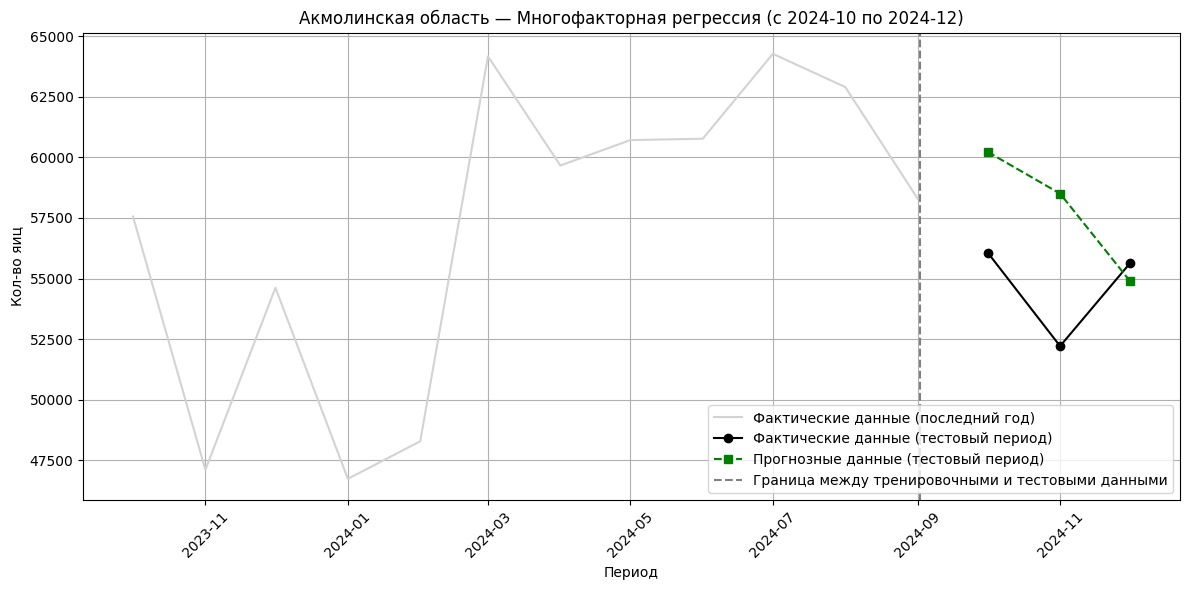

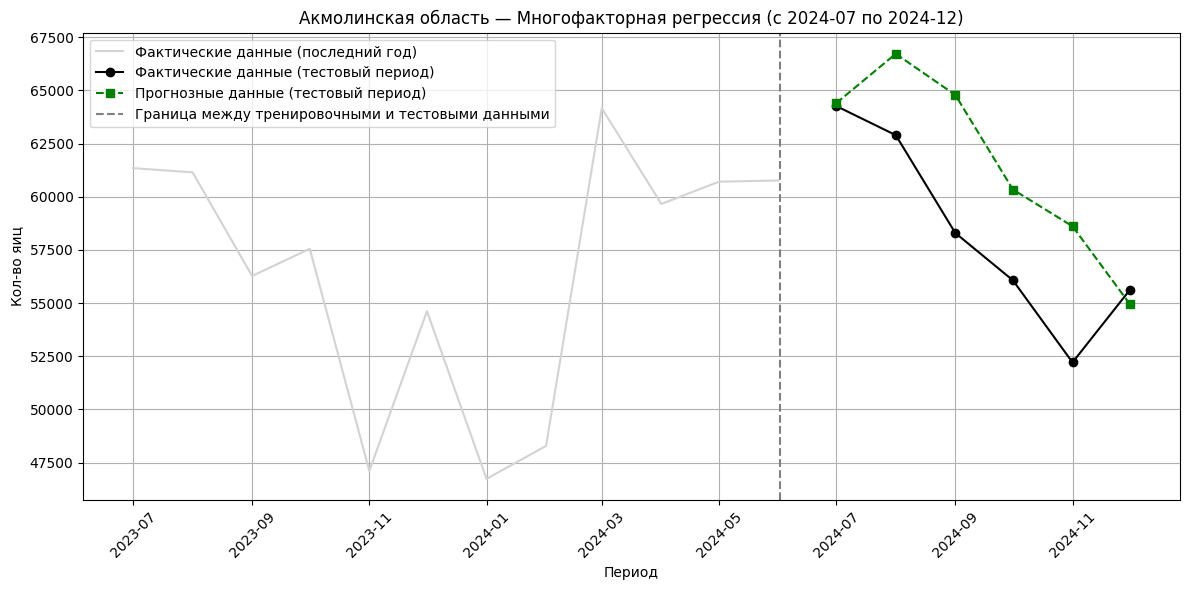

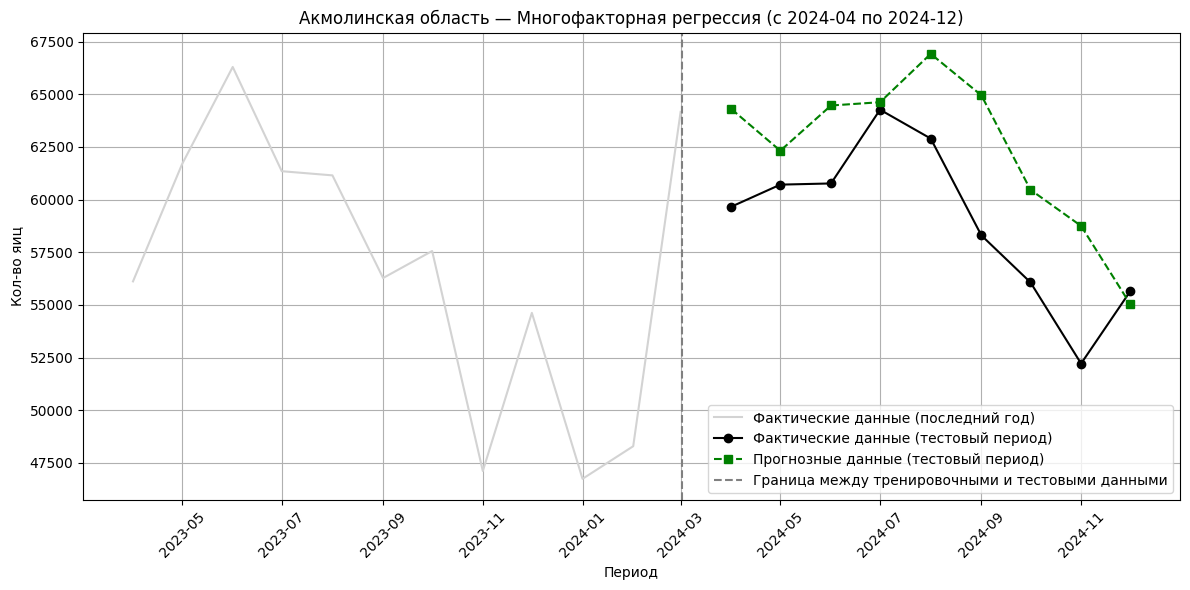

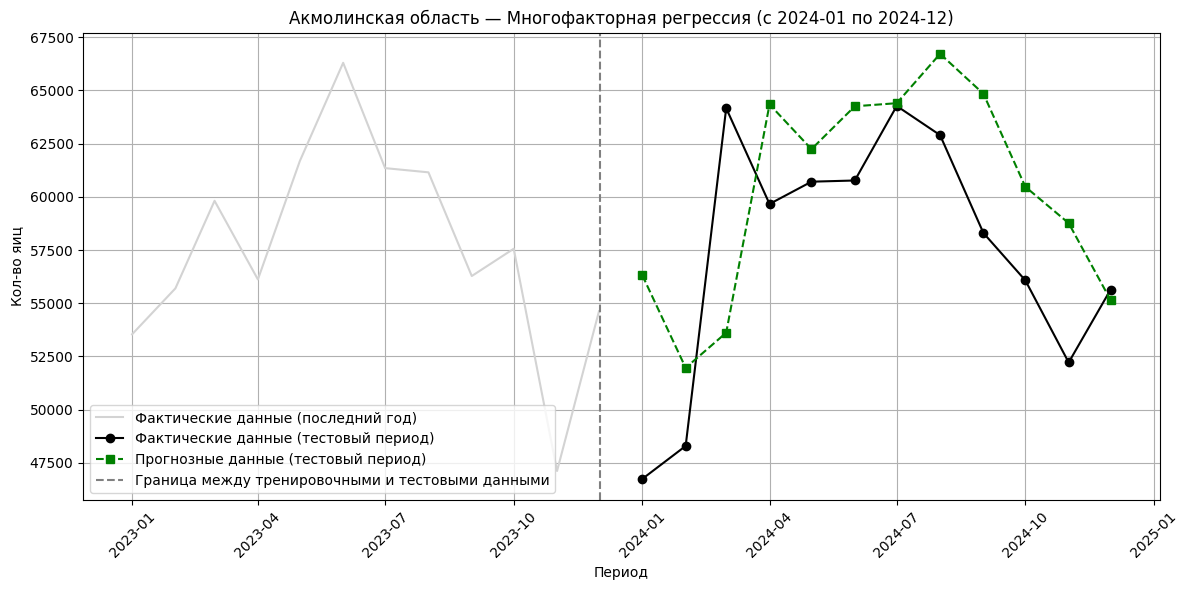

In [47]:
results = []

# Define 4 rolling test sets for 2024
horizons = [3, 6, 9, 12]

for horizon in horizons:

    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    X_train = sm.add_constant(train_df[features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        # "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Многофакторная регрессия (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Кол-во яиц")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [48]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period         RMSE          MAE  MAPE (%)
0  2024-10 to 2024-12  4373.758893  3732.192194  6.935924
1  2024-07 to 2024-12  4406.176066  3637.103853  6.426640
2  2024-04 to 2024-12  4227.047591  3612.687208  6.257235
3  2024-01 to 2024-12  5574.299953  4620.118331  8.285649
4             Average  4645.320626  3900.525396  6.976362


#### SARIMA (auto-arima)

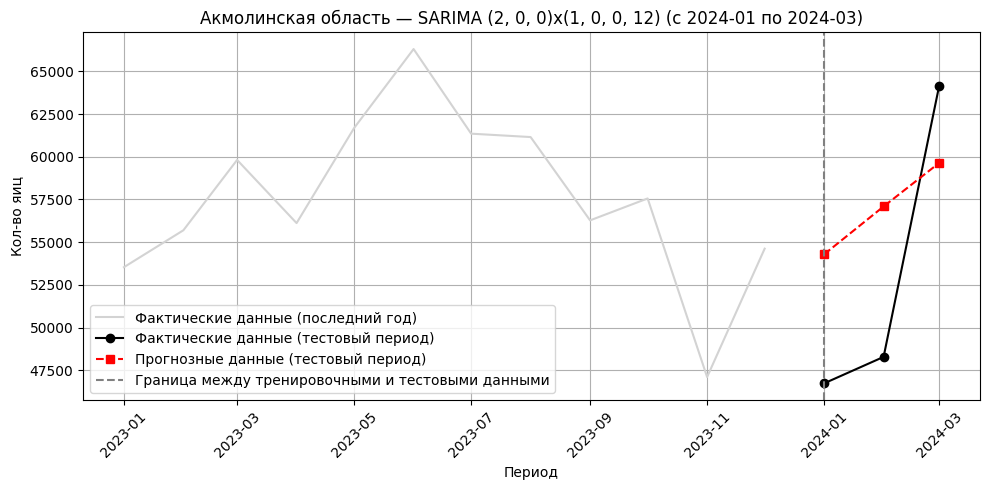

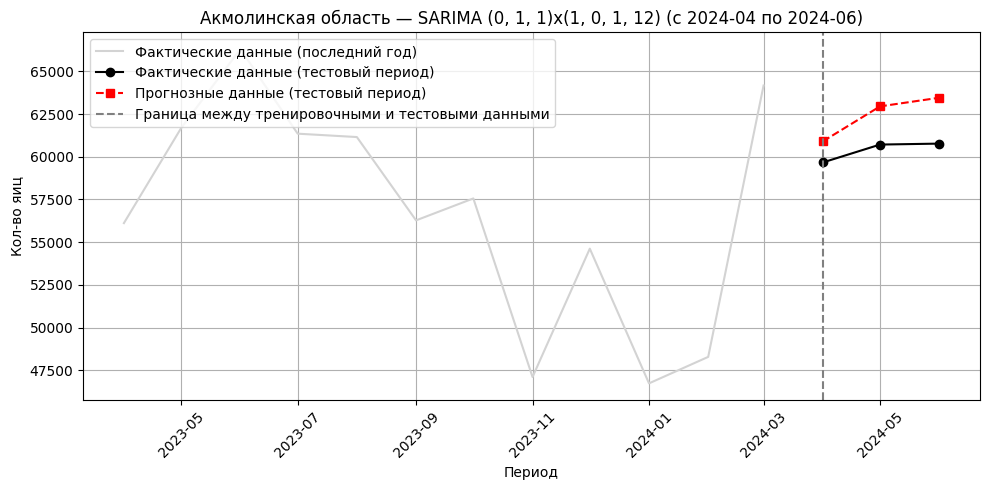

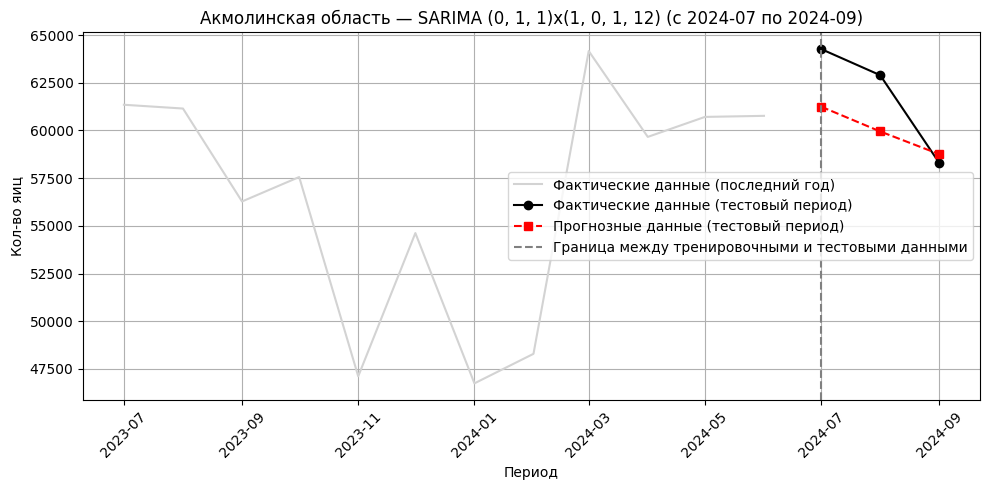

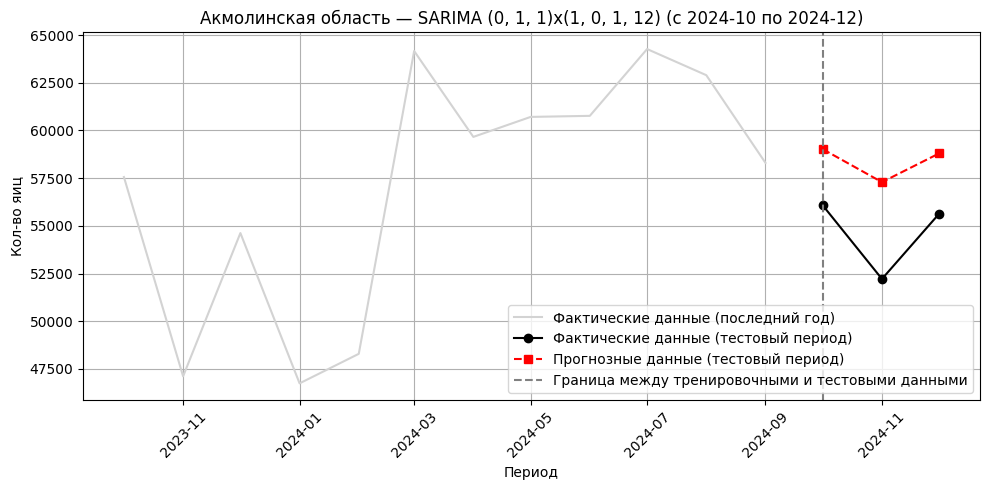

In [49]:
results = []

# Определим 4 тестовых периода на 3 месяца
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Разделим данные
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=3)
        forecast = pd.Series(forecast).reset_index(drop=True)


        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMA {model.order}x{model.seasonal_order} (с {test_start.strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Кол-во яиц")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        # print("Zero values in y_test:", (y_test == 0).sum())


    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [50]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period         RMSE          MAE   MAPE (%) SARIMA order  \
0  2024-01 to 2024-03  7186.879696  6959.191512  13.811408    (2, 0, 0)   
1  2024-04 to 2024-06  2138.188353  2050.444703   3.387888    (0, 1, 1)   
2  2024-07 to 2024-09  2452.637008  2143.237808   3.392359    (0, 1, 1)   
3  2024-10 to 2024-12  3849.313548  3728.218518   6.886614    (0, 1, 1)   
4             Average  3906.754651  3720.273135   6.869567          NaN   

  Seasonal order  
0  (1, 0, 0, 12)  
1  (1, 0, 1, 12)  
2  (1, 0, 1, 12)  
3  (1, 0, 1, 12)  
4            NaN  


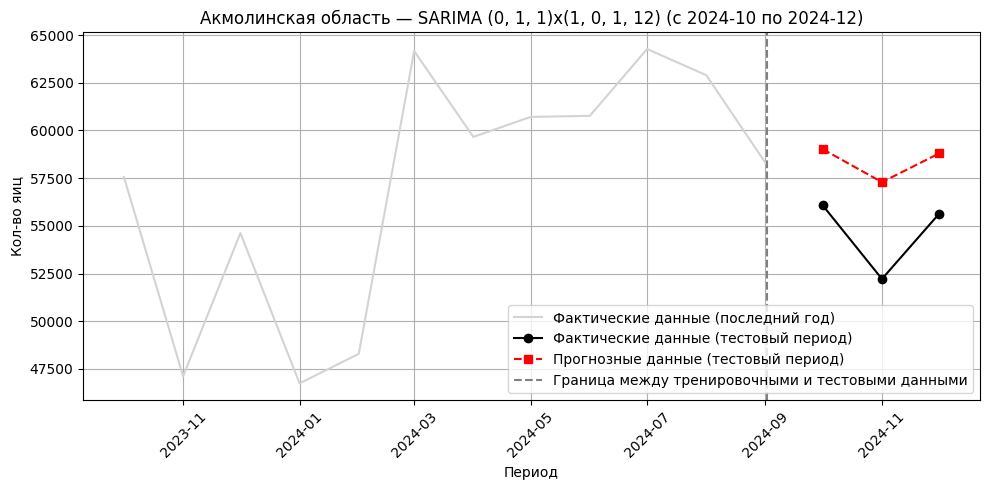

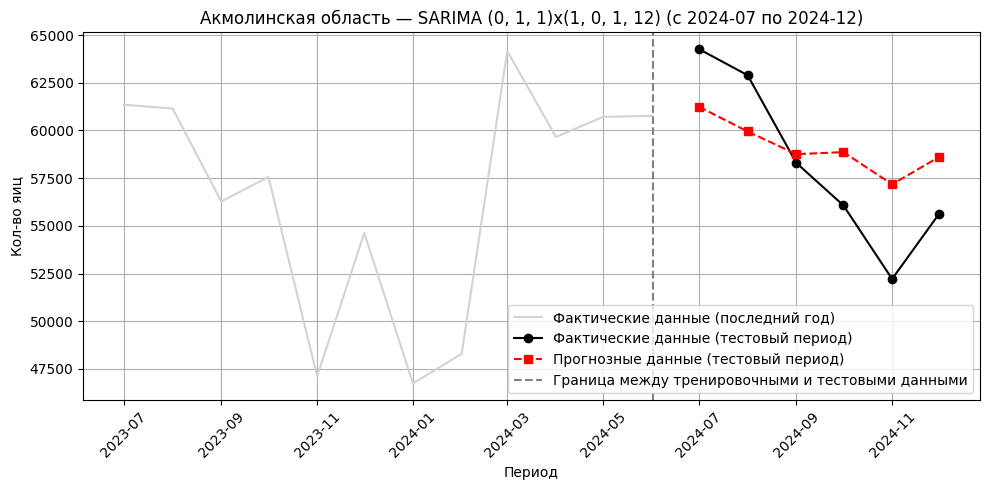

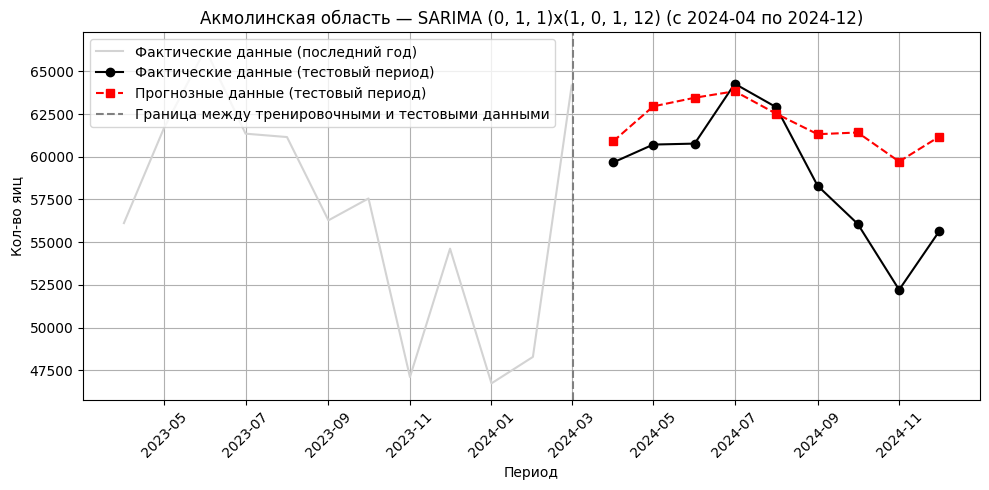

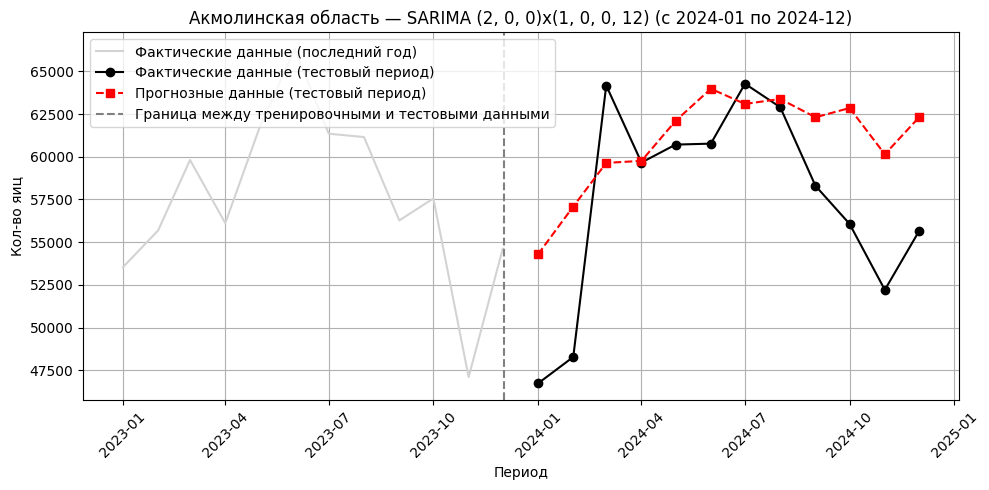

In [51]:
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:

    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)
    
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=horizon)
        forecast = pd.Series(forecast).reset_index(drop=True)

        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMA {model.order}x{model.seasonal_order} (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Кол-во яиц")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [52]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period         RMSE          MAE  MAPE (%) SARIMA order  \
0  2024-10 to 2024-12  3849.313548  3728.218518  6.886614    (0, 1, 1)   
1  2024-07 to 2024-12  3144.711443  2860.206519  5.001877    (0, 1, 1)   
2  2024-04 to 2024-12  3925.144310  3152.550742  5.608906    (0, 1, 1)   
3  2024-01 to 2024-12  5308.242711  4384.356049  8.157648    (2, 0, 0)   
4             Average  4056.853003  3531.332957  6.413761          NaN   

  Seasonal order  
0  (1, 0, 1, 12)  
1  (1, 0, 1, 12)  
2  (1, 0, 1, 12)  
3  (1, 0, 0, 12)  
4            NaN  


#### SARIMAX

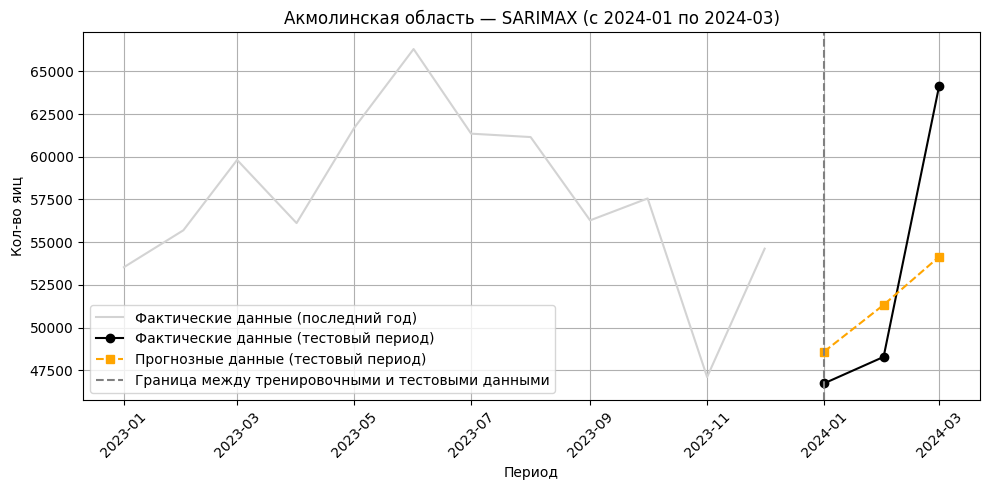

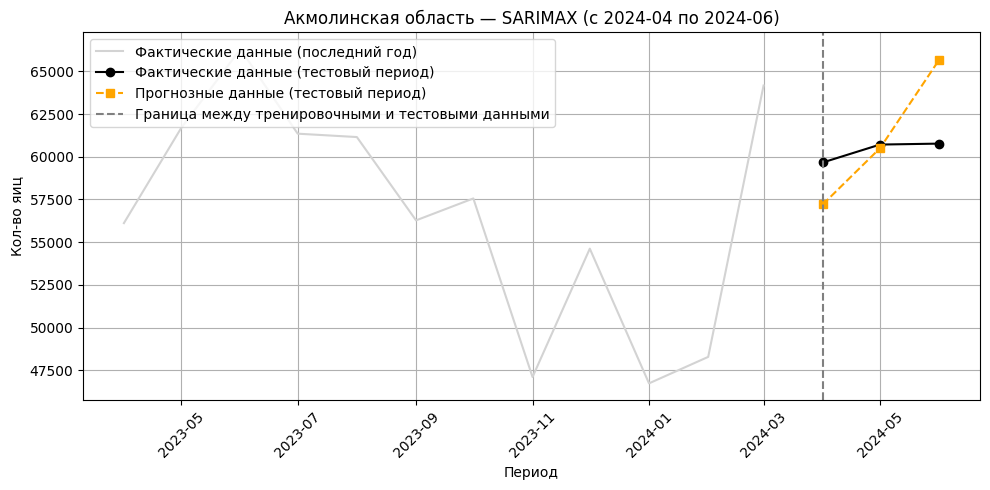

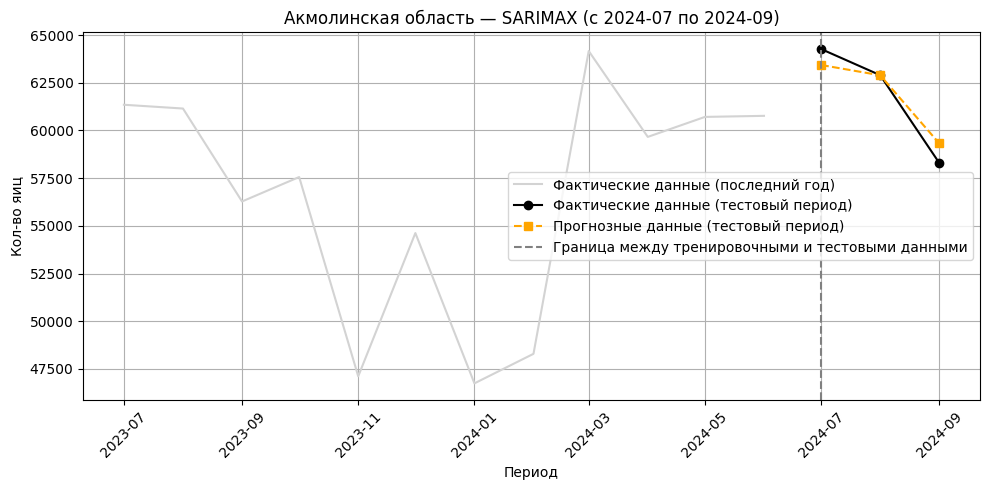

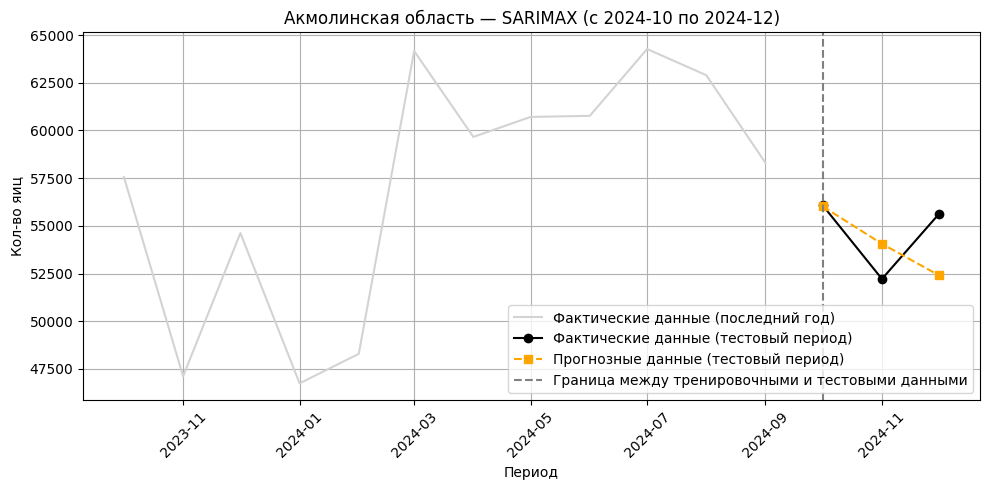

In [53]:
results = []

start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[features].reset_index(drop=True)
    exog_test = test_df[features].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(0, 1, 1),
            seasonal_order=(1, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=3, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMAX (с {start} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Кол-во яиц")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [54]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)



          Test period         RMSE          MAE  MAPE (%) SARIMA order  \
0  2024-01 to 2024-03  6136.568283  4971.096037  8.626659            0   
1  2024-04 to 2024-06  3172.758347  2525.653049  4.181270            0   
2  2024-07 to 2024-09   763.358249   621.739522  1.021835            0   
3  2024-10 to 2024-12  2154.341094  1713.882103  3.152523            0   
4             Average  3056.756493  2458.092677  4.245572                

  Seasonal order  
0             12  
1             12  
2             12  
3             12  
4                 


In [ ]:
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:
    # test_start = pd.to_datetime(start)
    # test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[features].reset_index(drop=True)
    exog_test = test_df[features].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(0, 1, 1),
            seasonal_order=(1, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=horizon, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"Акмолинская область — SARIMAX (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Кол-во яиц")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [ ]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)

#### Prophet

20:40:33 - cmdstanpy - INFO - Chain [1] start processing
20:40:33 - cmdstanpy - INFO - Chain [1] done processing


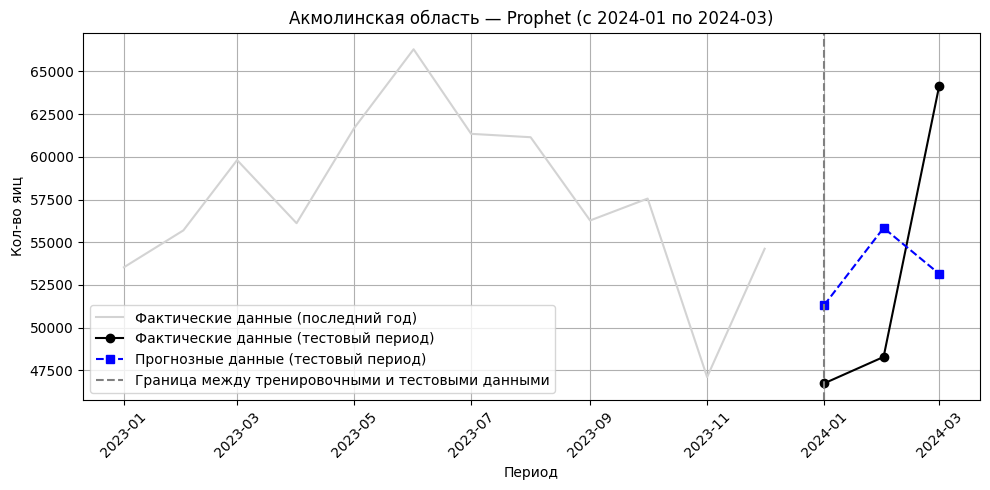

20:40:33 - cmdstanpy - INFO - Chain [1] start processing
20:40:33 - cmdstanpy - INFO - Chain [1] done processing


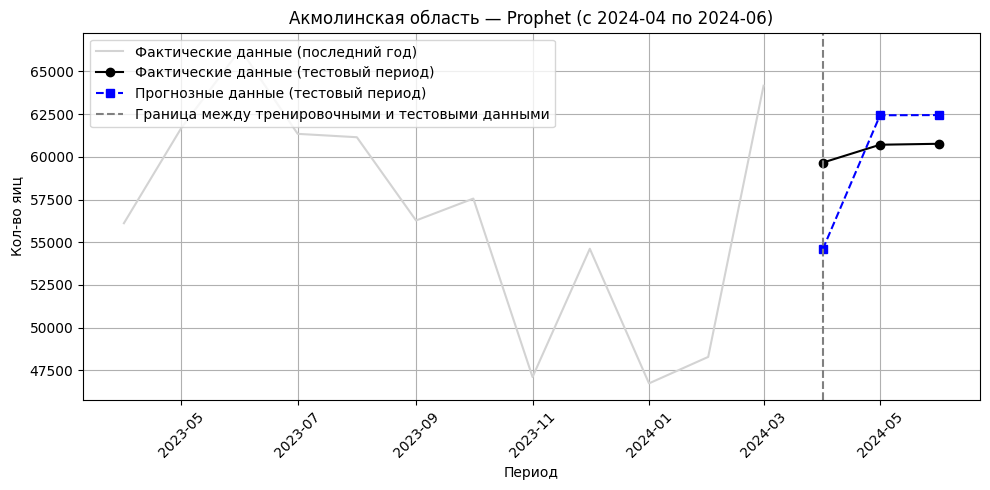

20:40:34 - cmdstanpy - INFO - Chain [1] start processing
20:40:34 - cmdstanpy - INFO - Chain [1] done processing


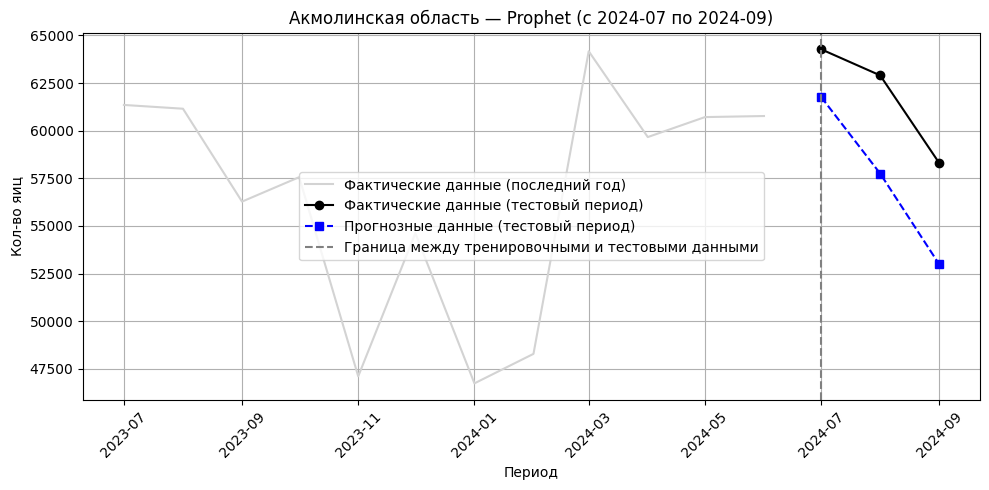

20:40:34 - cmdstanpy - INFO - Chain [1] start processing
20:40:34 - cmdstanpy - INFO - Chain [1] done processing


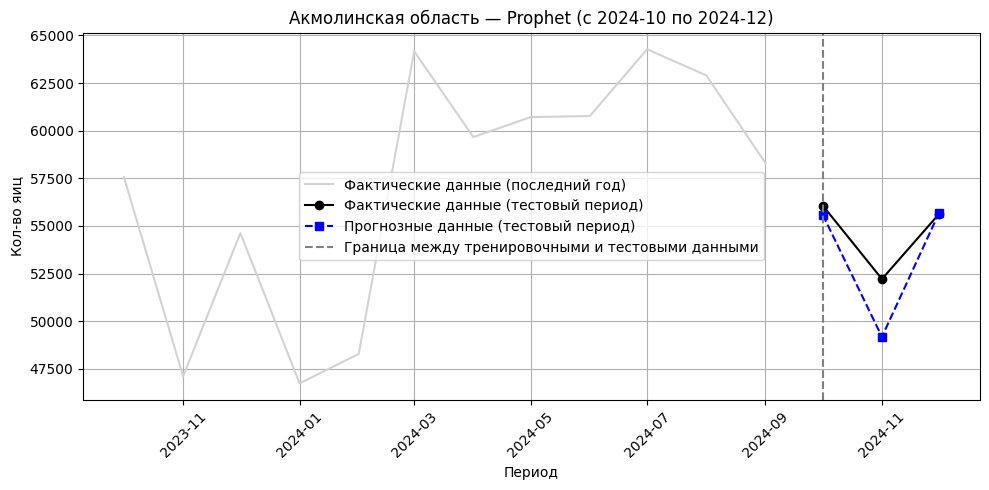

In [57]:
results = []

# Define 4 test periods
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Train/test split
    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Initialize Prophet
    model = Prophet()

    # Optional: add regressors
    # model.add_regressor("Температура_t-1")
    # prophet_train["Температура_t-1"] = train_df["Температура_t-1"].values
    # prophet_test["Температура_t-1"] = test_df["Температура_t-1"].values

    # Fit
    model.fit(prophet_train)

    # Create future dataframe
    future = model.make_future_dataframe(periods=3, freq="M")
    forecast = model.predict(future)
# forecast
# prophet_test

    # Extract forecast for test period only
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Prophet (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Кол-во яиц")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [58]:
results_df = pd.DataFrame(results)
avg = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg])], ignore_index=True)
print(results_df)

          Test period         RMSE          MAE   MAPE (%)
0  2024-01 to 2024-03  8152.146268  7715.994323  14.201970
1  2024-04 to 2024-06  3243.419354  2827.005206   4.704546
2  2024-07 to 2024-09  4512.010543  4324.206312   7.068725
3  2024-10 to 2024-12  1774.306054  1194.252585   2.263415
4             Average  4420.470555  4015.364606   7.059664


20:40:44 - cmdstanpy - INFO - Chain [1] start processing
20:40:44 - cmdstanpy - INFO - Chain [1] done processing


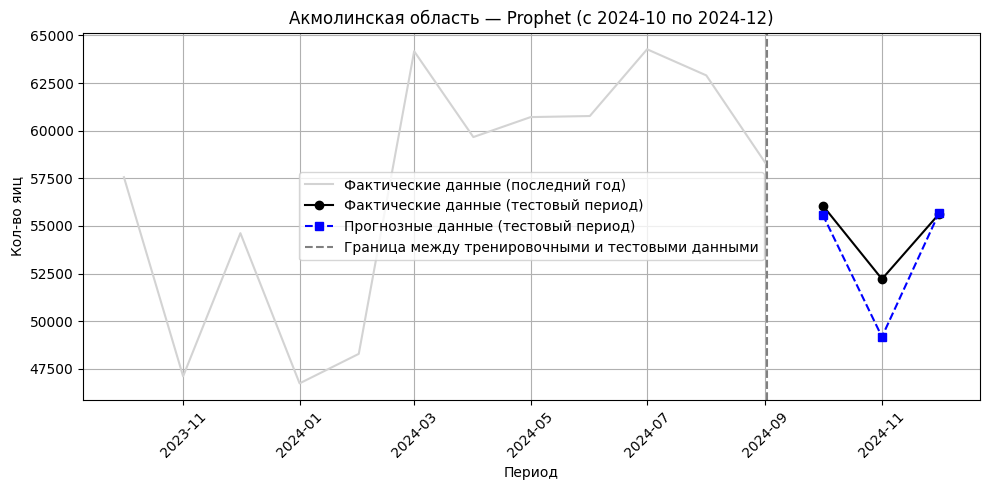

20:40:45 - cmdstanpy - INFO - Chain [1] start processing
20:40:45 - cmdstanpy - INFO - Chain [1] done processing


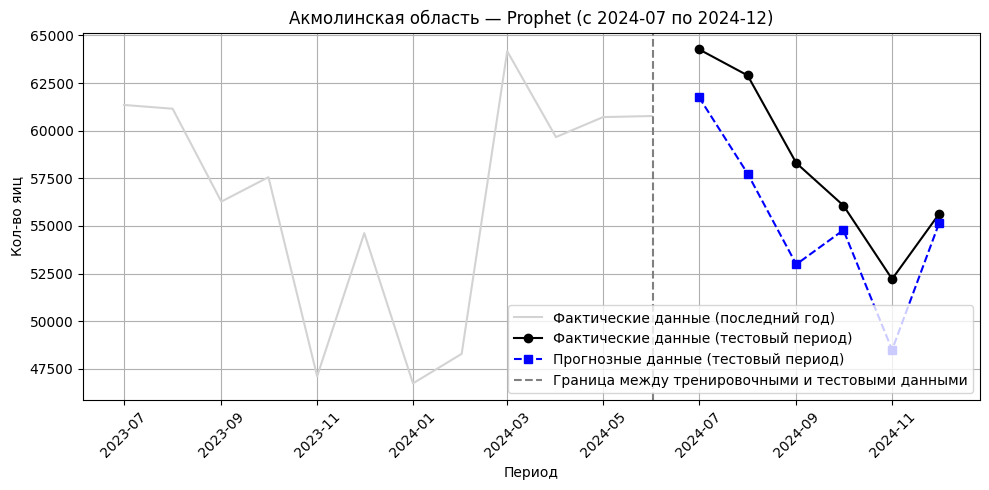

20:40:45 - cmdstanpy - INFO - Chain [1] start processing
20:40:45 - cmdstanpy - INFO - Chain [1] done processing


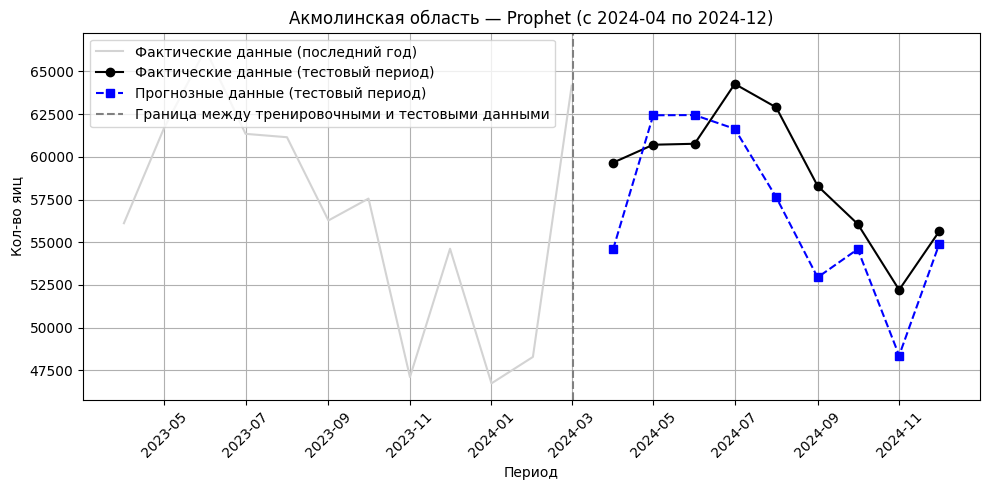

20:40:46 - cmdstanpy - INFO - Chain [1] start processing
20:40:46 - cmdstanpy - INFO - Chain [1] done processing


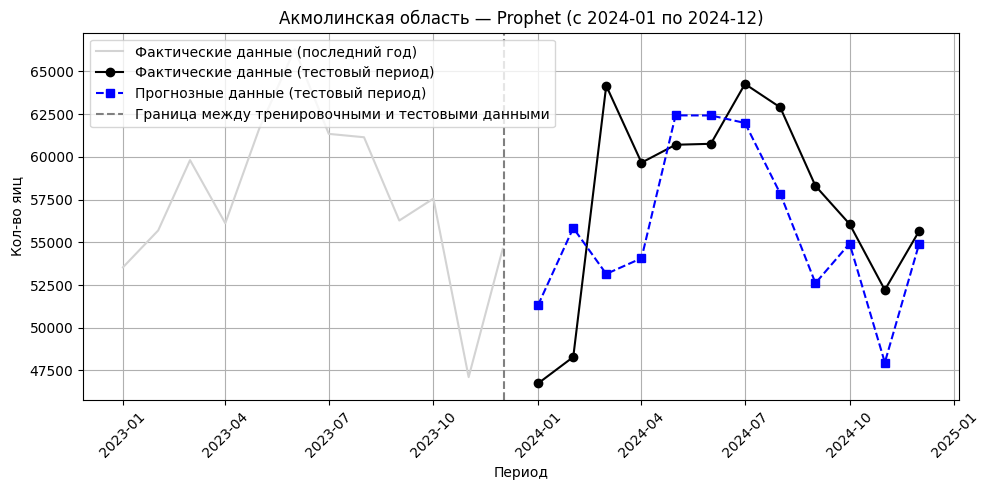

In [59]:
horizons = [3, 6, 9, 12]
results = []

for horizon in horizons:

    # Define train/test split
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Fit Prophet
    model = Prophet()
    model.fit(prophet_train)

    # Forecast
    future = model.make_future_dataframe(periods=horizon, freq="M")
    forecast = model.predict(future)

    # Extract matching forecasted months
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"Акмолинская область — Prophet (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Кол-во яиц")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [60]:
# Summary table
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)

          Test period         RMSE          MAE  MAPE (%)
0  2024-10 to 2024-12  1774.306054  1194.252585  2.263415
1  2024-07 to 2024-12  3576.895825  3075.626135  5.246257
2  2024-04 to 2024-12  3532.981410  3087.852097  5.231876
3  2024-01 to 2024-12  5158.736814  4274.503699  7.535464
4                 NaN  3510.730026  2908.058629  5.069253


strength of correlation:
https://link.springer.com/article/10.1057/jt.2009.5#
https://resources.nu.edu/statsresources/correlation